In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import Progbar

tf.random.set_seed(0)

In [2]:
epochs = 4000
batch_size = 64
learning_rate = 2e-4

In [3]:
train = pd.read_csv("./data/train_data.csv")
test = pd.read_csv("./data/test_data.csv")
train = train.drop(train.iloc[581:597,:].index.values) # motor vibe 중 이상치 데이터 삭제

ss = RobustScaler()

scaled_train = ss.fit_transform(train)
scaled_test = ss.transform(test)

train_data = scaled_train
test_data = scaled_test

In [4]:
loss_function = keras.losses.MeanSquaredError()
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

In [5]:
class AutoDecoder(tf.keras.Model):
    def __init__(self):
        super(AutoDecoder, self).__init__()
        self.decoder = keras.layers.Dense(64, activation="relu", kernel_regularizer=keras.regularizers.l2(1e-9))
        self.encoder = keras.layers.Dense(units=8,input_shape=[2463, 1, 8])

    def call(self, inputs, training=True):
        if training:
            self.decoder.trainable = True
            self.encoder.trainable = True

        else:
            self.decoder.trainable = False
            self.encoder.trainable = False

        x = self.decoder(inputs)
        x = self.encoder(x)

        return x
    
    def train(self):
        self.decoder.trainable = True
        self.encoder.trainable = True

In [6]:
class Trainer:
    def __init__(self, model, epochs, batch, loss_function, optimizer, patience=10):
        self.model = model
        self.epochs = epochs
        self.batch = batch
        self.loss_function = loss_function
        self.optimizer = optimizer
        self.patience = patience
        self.min_loss = np.Inf
        self.counter = 0
        self.history = {'train_loss':[], 'val_loss':[]}

    def train(self, train_data, valid=False):
        if valid == False:
            valid_dataset = []
            train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_data)).batch(batch_size)
        else:
            train_dataset, valid_dataset = train_test_split(train_data, test_size=0.2, stratify=train_data[:, 7], random_state=0)
            n_train = len(train_dataset)
            n_val = len(valid_dataset)
            # train_dataset's shape : [step, batch_x_train, batch_y_train]
            train_dataset = tf.data.Dataset.from_tensor_slices((train_dataset, train_dataset)).batch(batch_size)
            valid_dataset = tf.data.Dataset.from_tensor_slices((valid_dataset, valid_dataset)).batch(batch_size)
            
        for epoch in range(self.epochs):
            self.model.train()
            print("\nStart of epoch %d" % (epoch,))

            # progress bar
            progBar = Progbar(len(train_dataset) * self.batch, stateful_metrics=['train_loss', 'val_loss'])
            total_loss = 0
            step = 0

            # start train
            for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
                with tf.GradientTape() as tape:
                    logits = self.model(x_batch_train, training=True)
                    loss = self.loss_function(y_batch_train, logits)
                grads = tape.gradient(loss, self.model.trainable_weights)
                self.optimizer.apply_gradients(zip(grads, self.model.trainable_weights))

                total_loss += loss
                if valid == False:
                    values = [('train_loss', loss)]
                    progBar.update((step + 1) * self.batch, values=values)
            train_loss = total_loss / n_train
            self.history['train_loss'].append(train_loss)
            
            # Calculate validation loss
            if n_val:
                # if validation set exists, do validation
                valid_loss = self.evaluate(valid_dataset)
                valid_loss /= n_val
                self.history['val_loss'].append(valid_loss)
                
                # Check if validation loss has improved, if not increase counter
                if valid_loss >= self.min_loss:
                    self.counter += 1
                else:
                    self.min_loss = valid_loss
                    self.counter = 0
                
                # Stop training if counter has reached patience
                if self.counter >= self.patience:
                    print("Validation loss did not improve for %d epochs. Training stopped." % (self.patience,))
                    print(f"Best Validation Loss : {self.min_loss}")
                    break

                values = [('train_loss', train_loss), ('val_loss', valid_loss)]
                progBar.update(len(train_dataset) * self.batch, values=values, finalize=True)

        plot_graph(self.history)

    def evaluate(self, dataset):
        total_loss = 0
        for x, y in dataset:
            logits = self.model(x, training=False)
            loss = self.loss_function(y, logits)
            total_loss += loss
            
        return total_loss
    
def plot_graph(history, start=0):
    train_data = history["train_loss"][start:]
    val_data = history["val_loss"][start:]
    n_train = len(train_data)

    gap = n_train // 5

    plt.plot(train_data, linewidth=2, label="train")
    plt.plot(val_data, linewidth=2, label="val")
    
    plt.xticks(range(0, n_train+1, gap), range(start, start+n_train+1, gap))
    plt.legend(loc="upper right")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.show()

Model: "auto_decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               multiple                  576       
                                                                 
 dense_1 (Dense)             multiple                  520       
                                                                 
Total params: 1,096
Trainable params: 1,096
Non-trainable params: 0


_________________________________________________________________

Start of epoch 0
1984/1984 [==============================] - 0s 43us/step - train_loss: 0.0061 - val_loss: 0.0049

Start of epoch 1
1984/1984 [==============================] - 0s 38us/step - train_loss: 0.0049 - val_loss: 0.0039

Start of epoch 2
1984/1984 [==============================] - 0s 39us/step - train_loss: 0.0039 - val_loss: 0.0032

Start of epoch 3
1984/1984 [==============================] - 0s 40us/step - train_loss: 0.0031 - val_loss: 0.0026

Start of epoch 4
1984/1984 [==============================] - 0s 41us/step - train_loss: 0.0025 - val_loss: 0.0021

Start of epoch 5
1984/1984 [==============================] - 0s 39us/step - train_loss: 0.0020 - val_loss: 0.0017

Start of epoch 6
1984/1984 [==============================] - 0s 39us/step - train_loss: 0.0016 - val_loss: 0.0013

Start of epoch 7
1984/1984 [==============================] - 0s 39us/step - train_loss: 0.0013 - val_loss: 0.0011

Start

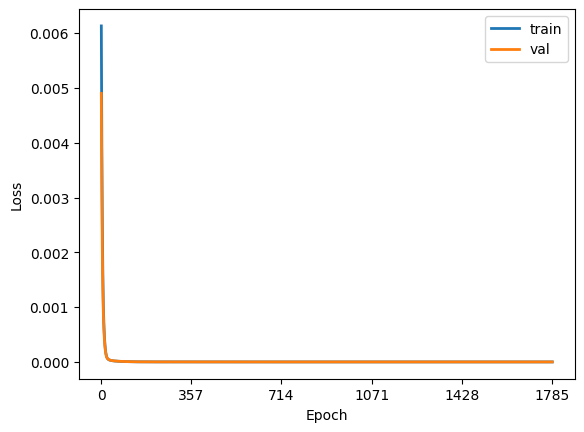

In [7]:
ad = AutoDecoder()
ad.build(input_shape=(None, 64, 8))
ad.summary()

trainer = Trainer(model=ad,
                  epochs=epochs,
                  loss_function=loss_function,
                  optimizer=optimizer,
                  batch=batch_size)
trainer.train(train_data=train_data,
              valid=True)

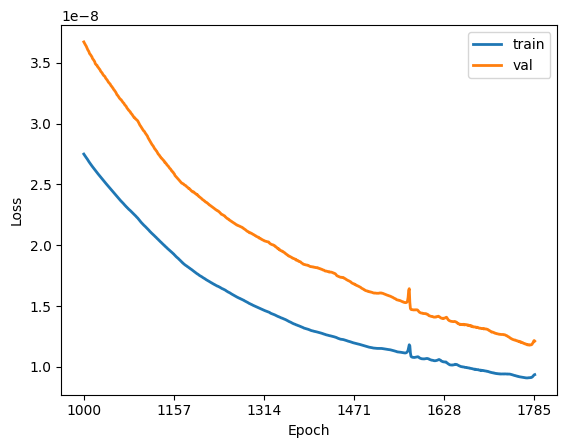

In [9]:
plot_graph(trainer.history, 1000)

2023-09-07 14:58:06.806715: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


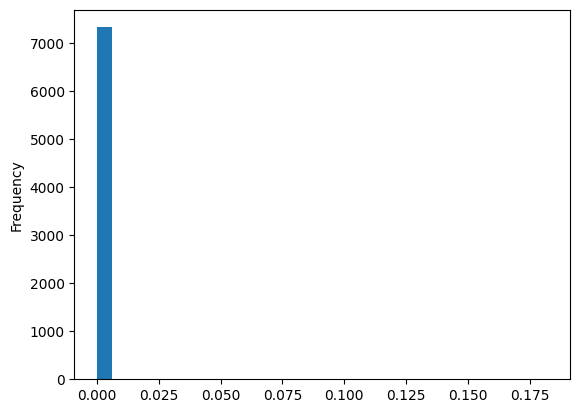

In [10]:
train_pred = ad.predict(train_data)
train_mse = np.mean(np.power(train_data - train_pred, 2), axis=1)
threshold = train_mse.max()

pred = ad.predict(test_data)

mse = np.mean(np.power(test_data - pred, 2), axis=1)
error_df = pd.DataFrame({"reconstruction_error" : mse, 'type' : test.type})
error_df["reconstruction_error"].plot(kind="hist",bins=30)
plt.show()

In [11]:
sub = pd.read_csv("./data/answer_sample.csv")

error_df['label'] = 0

index = error_df.reconstruction_error >= threshold
error_df.iloc[index, 2] = 1

sub["label"] = error_df["label"]

print(sub["label"].value_counts())
print("\ntype별 개수")
print(sub[sub.label == 1].type.value_counts())

0    7045
1     344
Name: label, dtype: int64

type별 개수
0    143
6    101
5     30
2     27
3     26
4     13
7      4
Name: type, dtype: int64


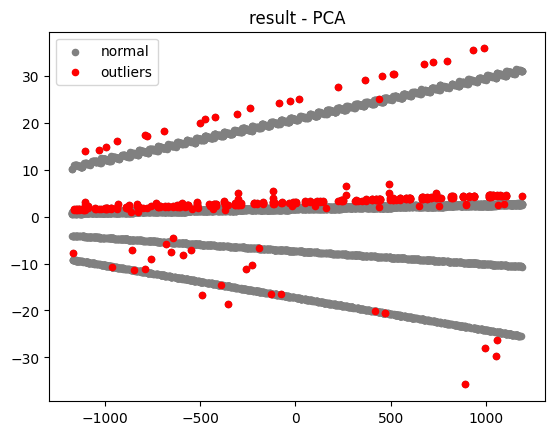

In [12]:
from sklearn.decomposition import PCA

ori_test = pd.read_csv('./data/test_data.csv')
ori_test["label"] = sub["label"].values

outliers=sub.loc[ori_test['label']==1]
outlier_index=list(outliers.index)

pca = PCA(2)
res = pd.DataFrame(pca.fit_transform(ori_test))

plt.title("result - PCA")
b1 = plt.scatter(res[0], res[1], c='gray', s=20, label='normal')
b2 = plt.scatter(res.iloc[outlier_index, 0], res.iloc[outlier_index, 1], c='red', s=20, edgecolor="red", label='outliers')
plt.legend()
plt.show()

In [13]:
col_threshold = np.power(train_data - train_pred, 2).max(axis=0)

error_df = pd.DataFrame({'anomalies' : (np.power(test_data - pred, 2) > col_threshold).sum(axis=1), 'type' : test.type})
error_df[error_df['anomalies'] != 0] = 1

sub = pd.read_csv("./data/answer_sample.csv")

sub["label"] = error_df["anomalies"]

print(sub["label"].value_counts())
print("\ntype별 개수")
print(sub[sub.label == 1].type.value_counts())

0    7015
1     374
Name: label, dtype: int64

type별 개수
0    143
6    101
3     50
5     30
2     27
4     13
1      6
7      4
Name: type, dtype: int64


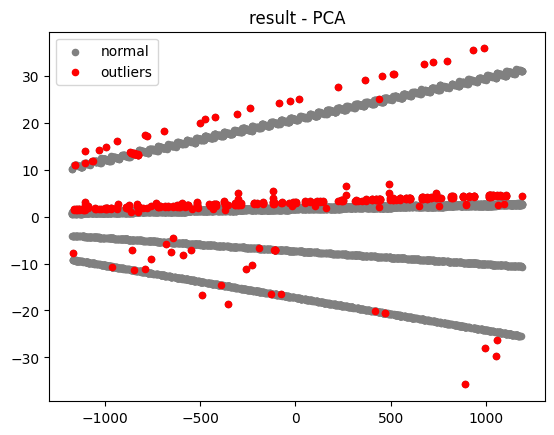

In [14]:
from sklearn.decomposition import PCA

ori_test = pd.read_csv('./data/test_data.csv')
ori_test["label"] = sub["label"].values

outliers=sub.loc[ori_test['label']==1]
outlier_index=list(outliers.index)

pca = PCA(2)
res = pd.DataFrame(pca.fit_transform(ori_test))

plt.title("result - PCA")
b1 = plt.scatter(res[0], res[1], c='gray', s=20, label='normal')
b2 = plt.scatter(res.iloc[outlier_index, 0], res.iloc[outlier_index, 1], c='red', s=20, edgecolor="red", label='outliers')
plt.legend()
plt.show()

In [13]:
sub.to_csv("AD_64.csv", index=False)